## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

## Ref
* https://www.twblogs.net/a/5c114f3ebd9eee5e40bb299e/
* monitor：被監測的量
* factor：每次減少學習率的因子，學習率將以lr=lr*factor的形式減少
* patience：當patience個epoch過去而模型性能不提升時，學習率減少的動作會被觸發
* mode：‘auto’，‘min’，‘max’之一，在min模式下，如果檢測值不再降低，則觸發學習率減少。在max模式下，當檢測值不再上升則觸發學習率減少。
* epsilon：閾值，用來確定是否進入檢測值的“平原區“
* cooldown：學習率減少後，會經過cooldown個epoch才重新進行正常操作
* min_lr：學習率的下限

## Note
* 此次作業中，分別以optimizer, factor, patience各有不同參數的情況下去做組合式測試
* 每一次epoch的調整，都可以看到accuracy有明顯提升
* 由結果圖可以觀察到，為exp4的accuracy最佳，達0.7699
* Numbers of exp: 4, reduce_factor: 0.20, reduce_patient: 3 (optimizers:SGD)


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2, 0.5]
redice_lr_patient = [3, 5]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,  #每次減少學習率的因子，學習率將以lr=lr*factor的形式減少
                              min_lr=1e-12,                 #學習率的下限
                              monitor='val_loss',           #被監測的量
                              patience=reduce_patient,   #當patience個epoch過去而模型性能不提升時，學習率減少的動作會被觸發
                              verbose=1) 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

W0806 23:51:31.715424 44268 deprecation.py:323] From E:\Users\moon\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 14s 284us/step - loss: 2.2587 - acc: 0.2629 - val_loss: 2.2269 - val_acc: 0.2983
Epoch 2/25
50000/50000 [==============================] - 12s 233us/step - loss: 1.7473 - acc: 0.3925 - val_loss: 1.8413 - val_acc: 0.3757
Epoch 3/25
50000/50000 [==============================] - 11s 219us/step - loss: 1.6220 - acc: 0.4347 - val_loss: 1.6971 - val_acc: 0.4156
Epoch 4/25
50000/50000 [==============================] - 11s 219us/step - loss: 1.5482 - acc: 0.4623 - val_loss: 1.6367 - val_acc: 0.4306
Epoch 5/25
50000/50000 [==============================] - 11s 219us/step - loss: 1.4938 - acc: 0.4797 - val_loss: 1.6042 - val_acc: 0.4385
Epoch 6/25
50000/50000 [==============================] - 11s 222us/step - loss: 1.4505 - acc: 0.4969 - val_loss: 1.5728 - val_acc: 0.4508
Epoch 7/25
50000/50000 [==============================] - 11s 221us/step - loss: 1.4122 - acc: 0.5107 - val_loss: 1.

50000/50000 [==============================] - 11s 225us/step - loss: 1.0026 - acc: 0.6585 - val_loss: 1.4366 - val_acc: 0.5051
Epoch 24/25
50000/50000 [==============================] - 11s 223us/step - loss: 0.9816 - acc: 0.6694 - val_loss: 1.4561 - val_acc: 0.4946
Epoch 25/25
50000/50000 [==============================] - 11s 225us/step - loss: 0.9617 - acc: 0.6764 - val_loss: 1.4449 - val_acc: 0.4981
Numbers of exp: 2, reduce_factor: 0.50, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden

50000/50000 [==============================] - 11s 219us/step - loss: 1.5791 - acc: 0.4486 - val_loss: 1.6752 - val_acc: 0.4161
Epoch 10/25
50000/50000 [==============================] - 11s 216us/step - loss: 1.5541 - acc: 0.4580 - val_loss: 1.6612 - val_acc: 0.4177
Epoch 11/25
50000/50000 [==============================] - 11s 219us/step - loss: 1.5333 - acc: 0.4652 - val_loss: 1.6480 - val_acc: 0.4231
Epoch 12/25
50000/50000 [==============================] - 11s 218us/step - loss: 1.5126 - acc: 0.4719 - val_loss: 1.6354 - val_acc: 0.4285
Epoch 13/25
50000/50000 [==============================] - 11s 215us/step - loss: 1.4931 - acc: 0.4800 - val_loss: 1.6266 - val_acc: 0.4326
Epoch 14/25
50000/50000 [==============================] - 11s 216us/step - loss: 1.4750 - acc: 0.4841 - val_loss: 1.6146 - val_acc: 0.4325
Epoch 15/25
50000/50000 [==============================] - 11s 215us/step - loss: 1.4601 - acc: 0.4915 - val_loss: 1.6044 - val_acc: 0.4400
Epoch 16/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 17s 349us/step - loss: 2.6572 - acc: 0.1624 - val_loss: 2.6075 - val_acc: 0.1931
Epoch 2/25
50000/50000 [==============================] - 12s 248us/step - loss: 2.3466 - acc: 0.2262 - val_loss: 2.3866 - val_acc: 0.2320
Epoch 3/25
50000/50000 [==============================] - 12s 247us/step - loss: 2.2222 - acc: 0.2587 - val_loss: 2.2801 - val_acc: 0.2535
Epoch 4/25
50000/50000 [==============================] - 13s 252us/step - loss: 2.1439 - acc: 0.2787 - val_loss: 2.2027 - val_acc: 0.2696
Epoch 5/25
50000/50000 [==============================] - 12s 242us/step - loss: 2.0878 - acc: 0.2935 - val_loss: 2.1428 - val_acc: 0.2830
Epoch 6/25
50000/50000 [==============================] - 13s 253us/step - loss: 2.0461 - acc: 0.3044 - val_loss: 2.0988 - val_acc: 0.2944
Epoch 7/25
50000/50000 [==============================] - 13s 257us/step - loss: 2.0115 - acc: 0.3155 - val_loss: 2.

50000/50000 [==============================] - 12s 248us/step - loss: 1.7425 - acc: 0.3964 - val_loss: 1.8178 - val_acc: 0.3730
Epoch 24/25
50000/50000 [==============================] - 13s 252us/step - loss: 1.7351 - acc: 0.3991 - val_loss: 1.8127 - val_acc: 0.3756
Epoch 25/25
50000/50000 [==============================] - 12s 247us/step - loss: 1.7274 - acc: 0.4019 - val_loss: 1.8067 - val_acc: 0.3772
Numbers of exp: 7, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden

50000/50000 [==============================] - 12s 242us/step - loss: 1.0323 - acc: 0.6422 - val_loss: 1.5197 - val_acc: 0.4660
Epoch 10/25
50000/50000 [==============================] - 12s 240us/step - loss: 1.0072 - acc: 0.6524 - val_loss: 1.4694 - val_acc: 0.4856
Epoch 11/25
50000/50000 [==============================] - 12s 240us/step - loss: 0.9840 - acc: 0.6596 - val_loss: 1.3946 - val_acc: 0.5098
Epoch 12/25
50000/50000 [==============================] - 12s 232us/step - loss: 0.9613 - acc: 0.6694 - val_loss: 1.3622 - val_acc: 0.5196
Epoch 13/25
50000/50000 [==============================] - 12s 240us/step - loss: 0.9419 - acc: 0.6770 - val_loss: 1.3836 - val_acc: 0.5132
Epoch 14/25
50000/50000 [==============================] - 12s 244us/step - loss: 0.9213 - acc: 0.6833 - val_loss: 1.3604 - val_acc: 0.5245
Epoch 15/25
50000/50000 [==============================] - 12s 238us/step - loss: 0.9014 - acc: 0.6920 - val_loss: 1.4066 - val_acc: 0.5124
Epoch 16/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 19s 382us/step - loss: 2.5445 - acc: 0.1806 - val_loss: 2.3537 - val_acc: 0.2309
Epoch 2/25
50000/50000 [==============================] - 12s 240us/step - loss: 2.2049 - acc: 0.2624 - val_loss: 2.1906 - val_acc: 0.2756
Epoch 3/25
50000/50000 [==============================] - 12s 238us/step - loss: 2.0511 - acc: 0.3003 - val_loss: 2.0709 - val_acc: 0.3061
Epoch 4/25
50000/50000 [==============================] - 12s 239us/step - loss: 1.9539 - acc: 0.3274 - val_loss: 1.9883 - val_acc: 0.3240
Epoch 5/25
50000/50000 [==============================] - 12s 238us/step - loss: 1.8859 - acc: 0.3482 - val_loss: 1.9257 - val_acc: 0.3433
Epoch 6/25
50000/50000 [==============================] - 12s 243us/step - loss: 1.8323 - acc: 0.3649 - val_loss: 1.8753 - val_acc: 0.3593
Epoch 7/25
50000/50000 [==============================] - 12s 242us/step - loss: 1.7881 - acc: 0.3801 - val_loss: 1.

50000/50000 [==============================] - 12s 244us/step - loss: 1.4768 - acc: 0.4873 - val_loss: 1.6242 - val_acc: 0.4345
Epoch 24/25
50000/50000 [==============================] - 12s 242us/step - loss: 1.4660 - acc: 0.4924 - val_loss: 1.6163 - val_acc: 0.4371
Epoch 25/25
50000/50000 [==============================] - 13s 251us/step - loss: 1.4548 - acc: 0.4952 - val_loss: 1.6124 - val_acc: 0.4347


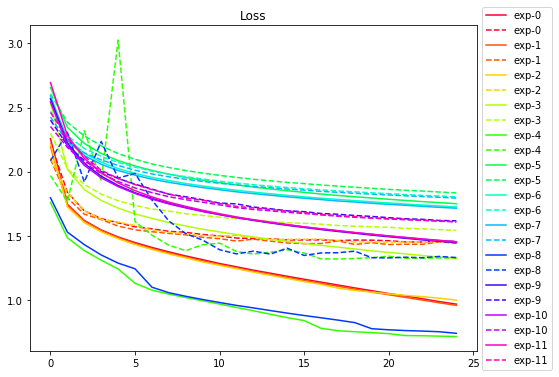

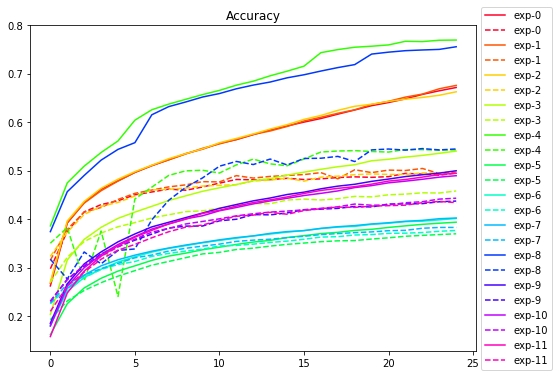

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()